In [1]:
import numpy as np
import pandas as pd
import gc
import time
import random
import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,roc_auc_score,roc_curve,f1_score
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from keras import backend as K
from keras.models import Sequential, load_model
from keras.optimizers import adam_v2
from keras.initializers import glorot_uniform, lecun_uniform
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import tree
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', 10)



In [2]:
# Random Seed
seed = 66666
np.random.seed(seed)
random.seed(seed)
# Constants
epochs = 25
batch_size = 1024
number_of_folds = 6

In [3]:
#merge train_id and train_tran
train_id= pd.read_csv("data/train_identity.csv",index_col='TransactionID')
train_tran= pd.read_csv('data/train_transaction.csv',index_col='TransactionID')
test_id = pd.read_csv("data/test_identity.csv",index_col='TransactionID')
test_tran = pd.read_csv("data/test_transaction.csv",index_col='TransactionID')
train_df = train_tran.merge(train_id, how='left', left_index=True, right_index=True)

In [4]:
train_Y=train_df['isFraud']
train_Y.head(10)

TransactionID
2987000    0
2987001    0
2987002    0
2987003    0
2987004    0
2987005    0
2987006    0
2987007    0
2987008    0
2987009    0
Name: isFraud, dtype: int64

In [5]:
tran_category_name = [ 'ProductCD',
                      'card1','card2','card3','card4','card5','card6',
                      'addr1', 'addr2',
                      'P_emaildomain','R_emaildomain',
                      'M1','M2','M3','M4','M5','M6','M7','M8','M9']
    
id_category_name_train = ['DeviceType','DeviceInfo'] + ['id_'+str(x) for x in range(12,39)]


v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314]
id_col_name = list(train_id.columns) 
col_name =['TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9'] + ['V'+str(x) for x in v] 
col_name += id_col_name
col_name

['TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 '

In [6]:
df=train_df[col_name]
df.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,V23,V26,V27,V30,V36,V37,V40,V41,V44,V47,V48,V54,V56,V59,V62,V65,V67,V68,V70,V76,V78,V80,V82,V86,V88,V89,V91,V107,V108,V111,V115,V117,V120,V121,V123,V124,V127,V129,V130,V136,V138,V139,V142,V147,V156,V162,V165,V160,V166,V178,V176,V173,V182,V187,V203,V205,V207,V215,V169,V171,V175,V180,V185,V188,V198,V210,V209,V218,V223,V224,V226,V228,V229,V235,V240,V258,V257,V253,V252,V260,V261,V264,V266,V267,V274,V277,V220,V221,V234,V238,V250,V271,V294,V284,V285,V286,V291,V297,V303,V305,V307,V309,V310,V320,V281,V283,V289,V296,V301,V314,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,117.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,ya

## We ues mean value to place NAN for non-category features

In [7]:
replace_nan = []
for x in [f for f in df.columns if f not in ['index', 'TransactionID', 'TransactionDT'] + tran_category_name+id_category_name_train ]:
        imputer = SimpleImputer(strategy = 'mean')
        df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
        replace_nan.append(x) 
df.isnull().sum()

C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = imputer.fit_transform(df[x].values.reshape(-1, 1))
C:\Users\wwtma\AppData\Local\Temp/ipykernel_17884/539316335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 213, dtype: int64

In [8]:
#  we count the frequency of category feature to change category to int
for feat in (tran_category_name+id_category_name_train):
    df.loc[:,feat] = df.loc[:,feat].map(df.loc[:,feat].value_counts(dropna = False))
# we count the frequency of all other remaining 'Numerical' Features
for feat in [f for f in df.columns if f not in ['index', 'TransactionID', 'TransactionDT'] + tran_category_name+id_category_name_train]:
    df.loc[:,feat] = df.loc[:,feat].map(df.loc[:,feat].value_counts(dropna = False))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [9]:
df.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,V23,V26,V27,V30,V36,V37,V40,V41,V44,V47,V48,V54,V56,V59,V62,V65,V67,V68,V70,V76,V78,V80,V82,V86,V88,V89,V91,V107,V108,V111,V115,V117,V120,V121,V123,V124,V127,V129,V130,V136,V138,V139,V142,V147,V156,V162,V165,V160,V166,V178,V176,V173,V182,V187,V203,V205,V207,V215,V169,V171,V175,V180,V185,V188,V198,V210,V209,V218,V223,V224,V226,V228,V229,V235,V240,V258,V257,V253,V252,V260,V261,V264,V266,V267,V274,V277,V220,V221,V234,V238,V250,V271,V294,V284,V285,V286,V291,V297,V303,V305,V307,V309,V310,V320,V281,V283,V289,V296,V301,V314,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,823,439670,43,8933,521287,6651,277,148986,23078,520481,2429,552913,94456,453249,316791,316261,588111,451883,372435,341552,523142,447667,228938,453442,89677,489199,199337,320189,2979,280797,6225,168922,309841,517353,551623,515614,515614,1892,1139,525823,528588,528353,174246,319415,285468,251731,59865,132491,193324,346265,346252,346252,311236,290583,246500,298627,303466,169633,287644,514210,447823,401929,498764,495119,514076,319017,168969,168969,168969,168969,168969,168969,168969,295235,472700,448636,398513,513271,486457,513178,317801,273293,457915,434732,88757,476911,500998,500954,305135,589978,587242,588499,572121,589499,589218,587594,574712,546045,5134,558622,403766,547750,508595,508595,508595,508595,508595,508595,508589,508589,508589,450909,450909,450909,450909,450909,450909,450909,450909,450909,450721,450721,450721,450721,450721,450721,450721,450721,450721,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,449124,449124,449124,449124,449124,449124,29582,545552,354815,573290,462929,562740,449499,590524,5247,545552,354815,542892,561201,284599,487073,536687,567409,473273,446307,449668,524216,524216,453675,453675,585385,585385,515614,515614,449562,446307,463220,510496,449555,461200,451171,545427,451222,451279,585381,585371,585371,585793,585408,585377,585371,449562,449562,512975,450258,512954,517251,512735,449555,449555,449555,449555,449730,471874
2987001,86401,10683,439670,683,3056,521287,189217,29105,148986,42751,520481,352271,552913,228355,453249,316791,316261,588111,451883,372435,341552,523142,447667,183795,453442,389692,489199,199337,320189,280130,280797,262878,166571,309841,517353,551623,515614,515614,221930,279287,525823,528588,528353,174246,271100,271100,271100,196405,107567,193324,346265,346252,346252,279287,279287,279287,279287,279287,279287,216752,514210,447823,401929,498764,495119,514076,319017,186733,395228,357837,421263,397653,406519,264325,207068,472700,448636,398513,513271,486457,513178,317801,217817,457915,434732,402612,476911,500998,500954,305135,589978,587242,588499,572121,589499,589218,587594,574712,546045,366578,558622,403766,547750,508595,508595,508595,508595,508595,508595,508589,508589,508589,450909,450909,450909,450909,450909,450909,450909,450909,450909,450721,450721,450721,450721,450721,450721,450721,450721,450721,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,460110,449124,449124,449124,449124,449124,449124,519413,545552,354815,573290,462929,562740,449499,590524,316650,545552,354815,542892,561201,284599,487073,536687,567409,473273,446307,449668,524216,524216,453675,453

In [10]:
# get the features we want to use.
feats = [f for f in df.columns if f not in ['index', 'TransactionID', 'TransactionDT']]

## Build the model

In [11]:
def EarlyStop(patience):
    return EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          mode = "min",
                          verbose = 1, 
                          patience = patience)

def ModelCheckpointFull(model_name):
    return ModelCheckpoint(model_name, 
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = True, 
                            save_weights_only = False, 
                            mode = 'min', 
                            period = 1)

# Input Shape
input_shape = df[feats].shape[1]

# Define CNN 1D model
def create_model():
    model = Sequential()
    model.add(Conv1D(96, 2, activation = 'relu', input_shape=(input_shape, 1), kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())       
    model.add(Dropout(0.25))
    model.add(Conv1D(96, 1, activation = 'relu', kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())       
    model.add(Flatten())
    model.add(Dropout(0.25))    
    model.add(Dense(96, activation = 'relu', kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed = seed)))
    model.compile(loss = 'binary_crossentropy', optimizer = adam_v2.Adam(learning_rate = 0.001), metrics = ['accuracy'])
    
    return model

## divide train set and test set

In [12]:
train=df[feats]
X_train, X_test, Y_train, Y_test = train_test_split(train, train_Y, test_size = 0.30, random_state = 110)
Train_Cnn_X = X_train.values.reshape(-1, input_shape, 1)
Test_Cnn_X=X_test.values.reshape(-1, input_shape, 1)
# Arrays to store predictions
result = np.zeros(train.shape[0])

In [13]:
model = create_model()
model.fit(Train_Cnn_X, Y_train, 
                validation_data=(Test_Cnn_X, Y_test), 
                epochs=epochs, 
                batch_size=batch_size, 
                verbose=0,
                callbacks=[EarlyStop(10), ModelCheckpointFull('model.h5')])
# Delete Model
del model
gc.collect() 
model = load_model('model.h5')


Epoch 1: val_loss improved from inf to 0.10990, saving model to model.h5

Epoch 2: val_loss did not improve from 0.10990

Epoch 3: val_loss improved from 0.10990 to 0.10403, saving model to model.h5

Epoch 4: val_loss did not improve from 0.10403

Epoch 5: val_loss improved from 0.10403 to 0.10068, saving model to model.h5

Epoch 6: val_loss improved from 0.10068 to 0.09904, saving model to model.h5

Epoch 7: val_loss improved from 0.09904 to 0.09583, saving model to model.h5

Epoch 8: val_loss improved from 0.09583 to 0.09531, saving model to model.h5

Epoch 9: val_loss did not improve from 0.09531

Epoch 10: val_loss did not improve from 0.09531

Epoch 11: val_loss improved from 0.09531 to 0.09186, saving model to model.h5

Epoch 12: val_loss did not improve from 0.09186

Epoch 13: val_loss did not improve from 0.09186

Epoch 14: val_loss did not improve from 0.09186

Epoch 15: val_loss improved from 0.09186 to 0.09068, saving model to model.h5

Epoch 16: val_loss improved from 0.09

In [40]:
result = model.predict(Test_Cnn_X).reshape(-1,)
print('Fold %2d AUC : %.6f' % (1, roc_auc_score(Y_test, result))) 


Fold  1 AUC : 0.900749


Text(0.5, 1.0, 'AUC of CNN')

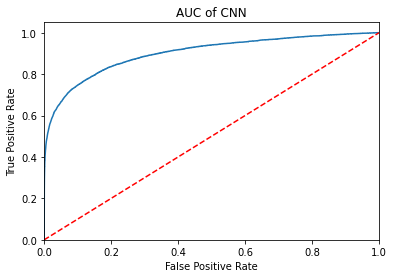

In [41]:
fpr, tpr, thresholds = roc_curve(Y_test, result)
plt.figure()
plt.plot(fpr, tpr, label='CNN = ')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC of CNN')

In [35]:
result_categary=[]
for i in range(len(result)):
    result_categary.append(round(result[i]))


## confusion_matrix

In [37]:
confusion_matrix(Y_test,result_categary)

array([[170688,    261],
       [  3954,   2259]], dtype=int64)

## Precision recall and F1 Score

In [48]:
from sklearn import metrics
print("Precision:",metrics.precision_score(Y_test,result_categary,average='macro'))
print("Recall:", metrics.recall_score(Y_test,result_categary))
print("F1 Score:",f1_score(Y_test,result_categary))

Precision: 0.9368939847557534
Recall: 0.36359246740704976
F1 Score: 0.5173479903813123
